### Machine Learning for Systems & Control 5SC28 2021-2022

# Exercise set Lecture 2: Gaussian Processes

## Table of contents

1. <a href="#Exercise-1:-Writing-your-own-GP">Exercise 1: Writing your own GP</a>
2. <a href="#Exercise-2:-Using-sklearn-GP">Exercise 2: Using sklearn GP</a>
3. <a href="#(Optional)-Exercise-3:-NARX-GP">(Optional) Exercise 3: NARX GP</a>
4. <a href="#Exercise-4:-Bayesian-optimization">Exercise 4: Bayesian optimization</a>

In this exercise set, you will implement your own version of a Radial Basis Function Gaussian Process, explore its properties and how it can be used. 

## Exercise 1: Writing your own GP

**a)** Based on Slide 32 and 20 for Lecture 2, implement GP regression with $\sigma_e^2 = 0.1$ (expected noise variance) and a squared exponential kernel with $\sigma^2 = 0.1$ (kernel width) using the `lownoise.mat` data set (place contents of the `dataW2.zip` in the same folder as the notebook) and plot the resulting function estimate on a fine grid of `xtest = np.linspace(-1,1,num=300)`. Analyse the qualitative fit w.r.t. the data. 

*tip: start by (i) finishing the `kernel` function. Next, use the `kernel` function in (ii) `compute_alpha` and in (iii) `pred_mean_and_var` to compute the mean.*

*tip: use np.linalg.solve instead of np.linalgh.inv*

$\hat \alpha = \left ( K_{xx} + \sigma_e^2 I_N \right ) ^{-1} Y$

**b)** Compute the resulting variance of the function estimate (slide 20) of 1.a and plot the 95% confidence bound (2 times the standard deviation) of the function. You can use the second part of `pred_mean_and_var` to complete this.

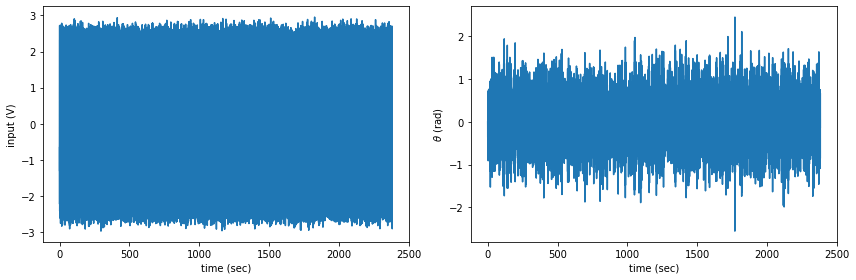

: 

: 

In [1]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
%matplotlib inline


######### Calling the dataset '1' or '2'  #########
ident_train = '1'
ident_test = '2'
path = os.getcwd()
datapath = path + '/data_sets'

#load data
train_data = np.load(datapath + f'/disk-measurement-dataset-{ident_train}.npz') #train data
X_train, y_train = train_data['u'], train_data['th'] # inputs
t = train_data['t'] # time samples
test_data = np.load(datapath + f'/disk-measurement-dataset-{ident_test}.npz') #validation data

X_val, X_test, y_val, y_test = train_test_split(test_data['u'], test_data['th'])

xtest = np.linspace(-1,1,num=1000) #xpoints for visualization


from matplotlib import pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(t,X_train)
plt.xlabel('time (sec)')
plt.ylabel('input (V)')
plt.subplot(1,2,2)
plt.plot(t,y_train)
plt.xlabel('time (sec)')
plt.ylabel('$\\theta$ (rad)')
plt.tight_layout()
plt.show()

def kernel(x1, x2, sigma2_ker):
    '''
    #make a matrix for two given inputs arrays
    #input: 
    #x1 of shape (N1)
    #x2 of shape (N2)
    #sigma2_ker float the squared kernel width
    
    #output
    #Kxx of shape (N1,N2)
    #Kxx[i,j] = np.exp(-(x1[i]-x2[j])**2/(2*sigma2_ker))) #a)
    '''
    #fast and compact: #a)
    diff = x1[:,None] - x2[None,:] #make a diff matrix of size (N1,N2) #a)
    Kxx = np.exp(-diff**2/(2*sigma2_ker)) #a)
    
#     #slow and explicit: #a)
#     Kxx = np.zeros(shape=(len(x1),len(x2))) #a)
#     for i in range(len(x1)): #a)
#         for j in range(len(x2)): #a)
#             Kxx[i,j] = np.exp(-(x1[i]-x2[j])**2/(2*sigma2_ker)) #a)
    
    return Kxx

def compute_alpha(x, y, sigma2_es, sigma2_ker):
    #for a given x and y data computes the alpha and Kxx 
    #uses the kernel function from above

    Kxx = kernel(x, x, sigma2_ker) #a=)
    alpha = np.linalg.solve(Kxx+sigma2_es*np.eye(len(x)), y) #a=)
    return alpha, Kxx #return both alpha and Kxx (required for variance estimation)

    
    
def pred_mean_and_var(xtest, x, Kxx, alpha, sigma2_es, sigma2_ker, return_std=True): 
    #conditionally return the standard deviation  
    K = lambda x1,x2: kernel(x1, x2, sigma2_ker=sigma2_ker) #shorthand for the kernel function use as K(x1,x2)
    
    Ktx = K(xtest, x) #a=)
    Ypred_mean = Ktx@alpha #a=)
    
    if not return_std:
        return Ypred_mean

    #finished at b)
#     Ypred_var = 
    #slow way: #b) 
    #Ypred_var = np.diag(K(xtest,xtest) - Ktx@np.linalg.inv(Kxx+sigma2_es*np.eye(len(x)))@Ktx.T) #b)
    #fast way: #b)
    Ypred_var = np.diag(K(xtest,xtest) - Ktx@np.linalg.solve(Kxx+sigma2_es*np.eye(len(x)), Ktx.T)) #b)
    
    return Ypred_mean, Ypred_var**0.5
    
sigma2_es = 0.1
sigma2_ker = 0.1
alpha, Kxx = compute_alpha(X_train, y_train, sigma2_es, sigma2_ker) # a) finish compute_alpha  
Ypred_mean = pred_mean_and_var(X_test, X_train, Kxx, alpha, sigma2_es, sigma2_ker, return_std=False) # a) finish pred_mean_and_var  

plt.plot(X_train,y_train,'.')
plt.plot(xtest,Ypred_mean)
plt.ylabel('y'); plt.xlabel('x'); plt.legend(['training data','mean predicted value']); plt.grid()
plt.title('pred mean')
plt.show()

if False: #switch to true when on b)
    Ypred_mean, Ypred_std = pred_mean_and_var(xtest, x, Kxx, alpha, sigma2_es, sigma2_ker)
    plt.plot(x,y,'.')
    plt.plot(xtest,Ypred_mean,'-')
    plt.fill_between(xtest,Ypred_mean-2*Ypred_std,Ypred_mean+2*Ypred_std,alpha=0.3)
    plt.ylabel('y'); plt.xlabel('x'); plt.legend(['training data','mean predicted value','predicted std']); plt.grid();
    plt.title('pred mean and std')
    plt.show()

**c)** Write down the influence of the kernel width $\sigma$ and the $\sigma_e$ on the predictions using the figures generated in the cell below.

**Answer c):** $\sigma_e$ regulates the uncertainty of each measurement point and $\sigma$ regulates the area each point can influence. 

In [ ]:
def plot(x,y,xtest,sigma2_es,sigma2_ker):
    
    alpha, Kxx = compute_alpha(x, y, sigma2_es, sigma2_ker)
    Ypred_mean, Ypred_std = pred_mean_and_var(xtest, x, Kxx, alpha, sigma2_es, sigma2_ker)
    
    plt.title(f'$\\sigma^2 = {sigma2_ker}$, $\\sigma^2_e = {sigma2_es}$ ')
    plt.plot(x,y,'.')
    plt.plot(xtest,Ypred_mean)
    plt.fill_between(xtest,Ypred_mean-2*Ypred_std,Ypred_mean+2*Ypred_std,alpha=0.3)
    plt.tight_layout()
    plt.grid()


plt.figure(figsize=(12,8))
i = 0
for sigma2_es in [0.01,0.1,1.0]:
    for sigma2_ker in [0.01,0.1,1.0]:
        i+=1
        plt.subplot(3,3,i)
        plot(x,y,xtest,sigma2_es,sigma2_ker)

plt.show()


**d)** Implement a grid search for $\sigma_e$ and $\sigma$ using the validation set (`xval` and `yval`). Complete the RMS function below and iterate over both arrays to create the grid. Use the cell after the next one to visualize the result. Does this result seem sensible?

**Answer d):** The obtained $\sigma_e$ is significantly lower than it should be which results in a standard deviation way too small (i.e. the results are overly confident). 

In [ ]:
def RMS(x, y, xval, yval, sigma2_es, sigma2_ker):
    alpha, Kxx = compute_alpha(x, y, sigma2_es, sigma2_ker) #d)
    yval_mean_pred = pred_mean_and_var(xval, x, Kxx, alpha, sigma2_es, sigma2_ker, return_std=False) #d)
    return np.mean((yval_mean_pred - yval)**2)**0.5 #d)

sigma2_es_list = np.geomspace(0.0001,3,num=21) #increasing value in log space
sigma2_ker_list = np.geomspace(0.0001,2,num=22) #increasing value in log space

mat_out = [] #d)
for sigma2_es in sigma2_es_list: #d)
    print(sigma2_es) #d)
    mat_out_row = [] #d)
    for sigma2_ker in sigma2_ker_list: #d)
        mat_out_row.append(RMS(x, y, xval, yval, sigma2_es, sigma2_ker)) #d)
    mat_out.append(mat_out_row) #d)
RMS_mat = np.array(mat_out) #d=)

In [ ]:
#plotting for d)
plt.contour(sigma2_ker_list, sigma2_es_list, np.clip(RMS_mat,-float('inf'),np.percentile(RMS_mat.flat,70)))
plt.loglog()
plt.colorbar()
plt.xlabel(r'$\sigma^2$')
plt.ylabel(r'$\sigma_e^2$')
plt.title("NRMS for both hyper parameters")
plt.show()

best1, best2 = np.unravel_index(np.argmin(RMS_mat),RMS_mat.shape)
sigma2_ker_list[best2], sigma2_es_list[best1]
plot(x,y,xtest,sigma2_es_list[best1],sigma2_ker_list[best2])
plt.show()

**e)** Do the same analysis and grid search for the marginal log-likelihood.

$$
\text{loglike} = 1/N \sum_i \log \left ( \frac{1}{\sigma \sqrt{2 \pi} }  e^{-(y_i-\hat{y_i})^2/(2 \sigma_y^2)}  \right ) 
$$

*tip: rewrite the expression above such to reduce floating-point errors*

In [ ]:
def loglike(x, y, xval, yval, sigma2_es, sigma2_ker):
    alpha, Kxx = compute_alpha(x, y, sigma2_es, sigma2_ker)
    yval_mean_pred, yval_std = pred_mean_and_var(xval, x, Kxx, alpha, sigma2_es, sigma2_ker, return_std=True)
    loglike = np.mean(-(yval-yval_mean_pred)**2/(2*yval_std**2) - np.log(yval_std) - np.log(2*np.pi)/2) #e=)
    return loglike

sigma2_es_list = np.geomspace(0.001,2,num=21)
sigma2_ker_list = np.geomspace(0.001,2,num=23)
mat_out_like = []
for sigma2_es in sigma2_es_list:
    print(sigma2_es)
    mat_out_row = []
    for sigma2_ker in sigma2_ker_list:
        mat_out_row.append(loglike(x, y, xval, yval, sigma2_es, sigma2_ker))
    mat_out_like.append(mat_out_row)
mat_out_like = np.array(mat_out_like)

In [ ]:
#plotting for e)
plt.contour(sigma2_ker_list, sigma2_es_list, np.clip(mat_out_like,np.percentile(mat_out_like.flat,30),float('inf')))
plt.colorbar()
plt.xlabel(r'$\sigma^2$')
plt.ylabel(r'$\sigma_e^2$')
plt.title("NRMS for both hyper parameters")

plt.loglog()
plt.show()
best1, best2 = np.unravel_index(np.argmax(mat_out_like),mat_out_like.shape)
print(sigma2_ker_list[best2], sigma2_es_list[best1])
print(np.max(mat_out_like))
plot(x,y,xtest,sigma2_es_list[best1],sigma2_ker_list[best2])

**f)** Does this result of marginal log-likelihood seems sensiable. 


**Answer f):** Yes, the data is compactly encapsulated by the standard deviation with a $\sigma_e$ which is not too low.

**g)** use `minimize` from `scipy.optimize` to find the maximum log likelihood.

In [ ]:
from scipy.optimize import minimize
#fun(x, *args) -> float (see docs)

# maximize marginal log likelihood
fun = lambda th: -loglike(x, y, xval, yval, th[0], th[1]) #f)
x0 = [sigma2_es_list[best1],sigma2_ker_list[best2]] #f)
fsol = minimize(fun, x0,bounds=[[1e-3,4],[1e-3,4]]) #f=)
# fsol = minimize(...)

sigma2_es_best, sigma2_ker_best = fsol.x
plot(x,y,xtest,sigma2_es_best, sigma2_ker_best)
plt.show()

## Exercise 2: Using sklearn GP

Now that you understand the basics of Gaussian processes let's switch to a nicely implemented version included in sklearn [1.7 Gaussian Processes](https://scikit-learn.org/stable/modules/gaussian_process.html). It includes features like:

* The hyperparameters of the kernel are optimized during the fitting of `GaussianProcessRegressor` by maximizing the log-marginal-likelihood (LML) (and using `scipy.optimize.minimize`). 
* Different kernels can be specified. Common kernels are provided, but it is also possible to specify custom kernels.

**a)** Noise term $\sigma_e$ can be interpreted as a kernel and is used as such in sklearn. Which kind of kernel $k(x_i, x_j)$ would produce the desired behaviour of a noise term?

**Answer a):** $k(x_i, x_j) = \delta_{ij} \sigma_e$ ($\delta_{ij}=1$ if $i=j$ and $\delta_{ij}=0$ if $i\neq j$.)

**b)** Construct a kernel as a combination of a Radial Basis Function `RBF` and a `WhiteKenel` using `+` and estimate a model using the x and y data generated below. Show the resulting model with `.predict` (set `return_std=True`).

*tip: read the documentation of Gaussian processes provided here [function doc](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html), [User guide](https://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process)*

*tip: set n_restarts_optimizer=10 for more robust hyperparamter optimization*

*note: sklearn uses multi-variate inputs so the x arrays need to have the shape of `(Nsamp, Nfeatures)` with `Nfeatures=1`*

In [ ]:
# f0 = lambda x: np.sin(3*x) + 0.5*np.random.normal(loc=0,scale=0.9,size=x.shape)
import numpy as np
from matplotlib import pyplot as plt
np.random.seed(43)
N = 100
noise = 0.1
f0 = lambda x: np.sin(3*x)

x = np.random.normal(loc=0,scale=0.8,size=N)
y = f0(x) + noise*np.random.normal(loc=0,scale=0.9,size=x.shape)
xtest = np.linspace(-4,4,num=150)
ytest = f0(xtest)

plt.plot(x,y,'.')
plt.grid(); plt.xlabel('x'); plt.xlabel('y'); plt.title('Data')
plt.show()


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared


#construct kernel
ker = RBF(length_scale=1) + WhiteKernel(noise_level=1.0) #b=)
#construct regressor
reg = GaussianProcessRegressor(ker,n_restarts_optimizer=10) #b=)
#fit regressor
reg.fit(x[:,None],y) 
#use regressor
ytest_p, ytest_std = reg.predict(xtest[:,None],return_std=True) #b=)

#plot result
plt.plot(xtest,ytest,'k',label='$f$')
plt.plot(xtest,ytest_p,label='pred mean')
plt.xlim(min(xtest),max(xtest))
plt.fill_between(xtest,ytest_p-2*ytest_std,ytest_p+2*ytest_std,alpha=0.3,label='pred 2*std')
plt.plot(x,y,'.',label='samples')
plt.grid(); plt.legend(); plt.xlabel('x'); plt.ylabel('y'); plt.title('sklearn est')
plt.show()


Gaussian processes are probabilistic in nature, hence we can sample them. 

**c)** Sample the obtained Gaussian process using `reg.sample_y` 7 times on the test set and plot and interpret the results.

In [ ]:
ysamps = reg.sample_y(xtest[:,None],n_samples=7) #c=)

plt.plot(xtest,ysamps,alpha=0.7)
plt.fill_between(xtest,ytest_p-2*ytest_std,ytest_p+2*ytest_std,alpha=0.3)
plt.xlim(min(xtest),max(xtest))
plt.grid(); plt.xlabel('x'); plt.ylabel('y'); plt.title('GP samples')
plt.show()

**d)** Repeat the exercise trying out some other kernels provided in sklearn [Kernels](https://scikit-learn.org/stable/modules/gaussian_process.html#kernel-operators), for instance, the Exp-Sine-Squared kernel (`ExpSineSquared`).

As seen in the implementation solving a GP requires solving a system of equations of $A x = y$ with a $A$ a shape of `(Nsamp,Nsamp)` which scales badly with an increasing data size. 

**e)** Measure the time it takes to estimate a model for different dataset sizes for `range(100,2500,200)` and save the time it takes to an array. Observe the scaling by plotting these saved times. (this computation should not take more than a minute)

*tip: use time.time() to get the current time in seconds from the time module*

**f)** How does the computation time scale with the number of samples (linear or worse?)

**Answer f):** The computational cost grows with $\mathcal{O}(n^3)$, this is especially visible for high dataset sizes.

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared
import numpy as np
def test(Nsamples):
    N = Nsamples
    noise = 0.1
    f0 = lambda x: np.sin(3*x)

    x = np.random.normal(loc=0,scale=0.8,size=N)
    y = f0(x) + noise*np.random.normal(loc=0,scale=0.9,size=x.shape)

    reg = GaussianProcessRegressor(RBF(length_scale=1) + WhiteKernel(noise_level=1.0)) 
    reg.fit(x[:,None],y) 
    return reg

import time
Nsamples_list = range(100,2500,200)
time_list = [] #e)
for Nsamples in Nsamples_list: #e)
    t_start = time.time() #e)
    test(Nsamples) #e)
    time_elapsed = time.time() - t_start #e)
    print(Nsamples, time_elapsed,'seconds') #e)
    time_list.append(time_elapsed) #e)

In [ ]:
#plotting here
plt.plot(Nsamples_list,time_list) #e)
p = np.polyfit(Nsamples_list,time_list,3) #poly fit #e)
f = lambda x: p[0]*x**3 + p[1]*x**2 + p[2]*x + p[3] #e)
plt.plot(Nsamples_list,[f(n) for n in Nsamples_list]) #e)
comps = " + ".join([f"{pi*2000**(3-i):.2} N'^{3-i}" for i,pi in enumerate(p)]) #e)
plt.legend(['time',f'fit {comps}']) #e)
print("where N'=N/2000") #e)
plt.grid(); plt.xlabel('N'); plt.ylabel('y') #e)
plt.show() #e)
#here the x**3 term is dominant at N=2000  #e)


## Exercise 3: NARX GP

From the last exercise, we saw that GP can estimate non-linear models. For this exercise we will apply GP to the same example we have used in the last exercise set (Week 1). 

**a)** Construct the data arrays `Xtrain, Xval, Ytrain, Yval` using the cell below and estimate a GP with RBF and white kernel. Make a residual plot of both the training and validation data. Now also include the uncertainty in the residual plot as a bar plot ([matplotlib errorbar plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html))


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
def f(upast,ypast):
    ukm2, ukm1 = upast
    ykm2, ykm1 = ypast
    ystar = (0.8 - 0.5 * np.exp(-ykm1 ** 2)) * ykm1 - (0.3 + 0.9 * np.exp(-ykm1 ** 2)) * ykm2 \
           + ukm1 + 0.2 * ukm2 + 0.1 * ukm1 * ukm2
    return ystar + np.random.normal(scale=0.01)

def get_NARX_data(ulist, f, na, nb):
    #init upast and ypast as lists.
    upast = [0]*nb 
    ypast = [0]*na 
    
    ylist = []
    for unow in ulist:
        #compute the current y given by f
        ynow = f(upast,ypast) 
        
        #update past arrays
        upast.append(unow)
        upast.pop(0)
        ypast.append(ynow)
        ypast.pop(0)
        
        #save result
        ylist.append(ynow)
    return np.array(ylist) #return result

na, nb = 2, 2

np.random.seed(42)
N = 500
ulist = np.random.normal(scale=1,size=N)
ylist = get_NARX_data(ulist,f,na,nb)

def make_training_data(ulist,ylist,na,nb):
    #Xdata = (Nsamples,Nfeatures)
    #Ydata = (Nsamples)
    Xdata = []
    Ydata = []
    #for loop over the data:
    for k in range(max(na,nb),len(ulist)): #skip the first few indexes such to 
        Xdata.append(np.concatenate([ulist[k-nb:k],ylist[k-na:k]])) 
        Ydata.append(ylist[k]) 
    return np.array(Xdata), np.array(Ydata)

Xdata, Ydata = make_training_data(ulist,ylist, na, nb)

from sklearn.model_selection import train_test_split 
Xtrain, Xval, Ytrain, Yval = train_test_split(Xdata, Ydata) 

In [ ]:
#fitting
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared

ker = RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01) #e=)
reg = GaussianProcessRegressor(ker, n_restarts_optimizer=10) #e=)
reg.fit(Xtrain,Ytrain) #e)

In [ ]:
#residual calculations and plotting
Ytrain_pred, Ytrain_pred_std = reg.predict(Xtrain,return_std=True) #e)
plt.figure(figsize=(12,5)) #e)
plt.plot(Ytrain) #e)
Ytrain_pred, Ytrain_pred_std = reg.predict(Xtrain,return_std=True) #e)
plt.errorbar(np.arange(len(Xtrain)), (Ytrain_pred), yerr=2*Ytrain_pred_std,fmt='.r') #e)
plt.grid(); plt.xlabel('sample'); plt.ylabel('y'); plt.legend(['measured','pred'])#e)
plt.show() #e)

plt.figure(figsize=(12,5)) #e)
plt.plot(Yval) #e)
Yval_pred, Yval_pred_std = reg.predict(Xval,return_std=True) #e)
plt.errorbar(np.arange(len(Xval)), (Yval_pred), yerr=2*Yval_pred_std,fmt='.r') #e)
plt.grid(); plt.xlabel('sample'); plt.ylabel('y'); plt.legend(['measured','pred'])#e)
plt.show() #e)

print(f'Validation NRMS= {np.mean((Yval_pred-Yval)**2)**0.5/np.std(Yval)}')#e)

**b)** We are also interested in the simulation performance of the model. Make a simulation and plot the residual and the NRMS. Is it lower than the polynomial model of the last exercise set?

**c)** Retry the exercise with different kernels and see if you can construct a kernel that is more accurate.

In [ ]:

np.random.seed(43)
utest = np.random.normal(scale=1.0,size=5000)
ytest = get_NARX_data(utest,f,na,nb)


model_now = reg #b=)
ytest_sim = get_NARX_data(utest,lambda u,y: model_now.predict(np.concatenate([u,y])[None,:])[0], na, nb)
plt.plot(ytest) #b)
plt.plot(ytest-ytest_sim) #b)
plt.grid(); plt.xlabel('index time'); plt.ylabel('y'); plt.legend(['measured','pred']) #b)
plt.show() #b)

print('NRMS=',np.mean((ytest-ytest_sim)**2)**0.5/np.std(ytest)) #b)


## Exercise 4: Bayesian optimization


In this exercise, we will explore the basics of Bayesian optimization. Consider the same setting as in Exercise 2, but now with a slightly modified process as seen below. 

**a)** For a given set of 1-dimensional inputs and outputs estimate a GP regressor in `get_model` with an `RBF` kernel and a `WhiteKernel`. Also, write `get_mean_std` which returns the mean and the standard deviation for a given regressor and test points.

**b)** Write the acquisition variance (`acquisition_var`) which takes in a number of test points and returns the estimated quality of picking this point based on the variance. 

**c)** Write the main `bayesian_optimization` function which in the first part samples `f` uniformly on the interval of `xmin` to `xmax` for `n_initial` points. Afterwards it should use the maximum of `acquisition_fun` (using `xtest_points`) to sample `f` more efficently until having `n_max` points. Define the test set as `xtest = np.linspace(-3,3,num=1000)`. Visualize the results using the plotting already present below. 

*tip: use np.argmax and np.append*

**d)** Also implement an acquisition function that weights the mean and the variance given by $\mu(x) (1-w) + \sigma(x) w$ which aims to find the maximum of the function while incorporating the variance of the function. Implement the `acquisition_weighted_mean_and_var` function and switching `have_d_been_implemented` to True. How does the behavior change for different values of $w$?

There are many options for acquisition function, Further reading: https://distill.pub/2020/bayesian-optimization/


In [ ]:
import warnings
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared, ConstantKernel
import numpy as np
from matplotlib import pyplot as plt
warnings.filterwarnings("ignore") #there might be some warning but this will supress them.

if True: #feel free to change the function to observe different different behaviour.
    f0 = lambda x: np.sin(3*x) + 0.2*x + 0.3 #no noise version
    xmin, xmax = -3., 3.
else:
    f0 = lambda x: x/20+x**2-x**4+np.exp(-(20*x)**2)/4
    xmin, xmax = -1., 1.
f = lambda x: f0(x) + np.random.normal(scale=0.002,size=np.array(x).shape) #noisy version

def get_model(x,y): 
    #return a regressor which is fitted to x,y
    ker = RBF(length_scale=0.4,length_scale_bounds=(0.01,5.0)) + \
          WhiteKernel(noise_level=1e-6,noise_level_bounds=(1e-7,1e-2)) #a)
    gp_reg = GaussianProcessRegressor(ker, n_restarts_optimizer=10) #a)
    gp_reg.fit(x[:,None],y) #a)
    return gp_reg #a)

def get_mean_std(gp_reg, xtest_points):
    ytest_pred_mean, ytest_pred_std = gp_reg.predict(xtest_points[:,None],return_std=True) #a)
    return ytest_pred_mean, ytest_pred_std
    
def acquisition_var(gp_reg, xtest_points):
    ytest_pred_mean, ytest_pred_std = get_mean_std(gp_reg, xtest_points) #b)
    return ytest_pred_std #b)

def acquisition_weighted_mean_and_var(gp_reg, xtest_points, weight=0.5):
    pass
    ytest_pred_mean, ytest_pred_std = get_mean_std(gp_reg, xtest_points) #d)
    return (1-weight)*ytest_pred_mean + weight*ytest_pred_std #d)

def bayesian_optimization(f, xmin, xmax, acquisition_fun, n_initial=5, n_max=15, seed=22):
    # f : is the function which need to be sampled
    # xmin : and xmax are the bounds on the x
    # acquisition_fun(gp_reg, some_x_points) : is the acquisition_fun on which the maximum need to be chosen as next point
    # n_initial : the number of points which are uniformly sampled from f before using bayesian optimizaiton
    # n_max : the buget of the number of maximum points that can be sampled from f 
    # (i.e. n_initial - n_max is the number of bayesian samples)
    
    rng = np.random.RandomState(seed) #you can use rng as a random generator, (e.g. rng.uniform(xmin, xmax) will sample uniform)
    x = rng.uniform(xmin, xmax, size=n_initial) #c=)
    y = f(x) #c=)
    xtest_points = np.linspace(xmin, xmax, num=1000) #c=)
    for n in range(n_initial+1, n_max+1): #c)
        gp_reg = get_model(x,y)
        acquisition_vals = acquisition_fun(gp_reg, xtest_points) #c=)
        xnew = xtest_points[np.argmax(acquisition_vals)] #c=)
        ynew = f(xnew) #c=)
        x = np.append(x,xnew) #c=)
        y = np.append(y,ynew) #c=)
    return x, y, get_model(x,y)

n_initial = 5
n_max = 15

rng = np.random.RandomState(21)
x_rand = rng.uniform(xmin, xmax, size=n_max) #random baseline
y_rand = f(x_rand)
x_test = np.linspace(xmin-0.05,xmax+0.05,num=500)

have_d_been_implemented = False  #switch to true when working on **d)**
if have_d_been_implemented:
    weight = 0.8
    #incorporate the weight factor in the function with a lambda function
    acquisition_weighted_mean_and_var_now = lambda gp_reg, xtest_points: \
        acquisition_weighted_mean_and_var(gp_reg, xtest_points, weight=weight)
else:
    acquisition_weighted_mean_and_var_now = None
    
for mode,acquisition_fun in enumerate([acquisition_var,acquisition_weighted_mean_and_var_now]):
    if acquisition_fun==None:
        continue
    if mode==0:
        print('Variance Acquision')
    else:
        print(f'Weighted mean and Variance Acquision (weight={weight})')
    #Bayesian
    x, y, reg = bayesian_optimization(f, xmin, xmax, acquisition_fun=acquisition_fun, n_initial=n_initial, n_max=n_max, seed=21)

    plt.figure(figsize=(12,4))
    for i,(xi, yi) in enumerate([(x_rand,y_rand),(x,y)]):
        plt.subplot(1,2,i+1)
        plt.plot(x_test,f(x_test),label='real')

        label = 'random samples' if i==0 else 'bayesian optimization'
        plt.plot(xi,yi,'o',label=label)

        reg = get_model(xi,yi)

        ytest_pred_mean, ytest_pred_std = get_mean_std(reg, x_test)
        plt.plot(x_test, ytest_pred_mean,label='pred mean')
        plt.fill_between(x_test, \
                         ytest_pred_mean+1.92*ytest_pred_std,\
                         ytest_pred_mean-1.92*ytest_pred_std,\
                         alpha=0.2,label='92% var')
        plt.grid()
        plt.legend()
        plt.ylabel('y')
        plt.xlabel('x')
    plt.show()
    
    if mode==1:
        M = x_test[np.argmax(f0(x_test))]
        x_near = np.linspace(M-0.05, M+0.05,num=300)
        plt.plot(x_near, f0(x_near),label='real')
        xlim, ylim = plt.xlim(), plt.ylim()
        plt.plot(xi,yi,'o',label='bayese samples')
        plt.xlim(xlim); plt.ylim(ylim)
        plt.plot(x_near, reg.predict(x_near[:,None]),label='pred')
        plt.legend()
        plt.grid()
        plt.ylabel('y')
        plt.xlabel('x')
        plt.show()



The grid-based optimization that we used above is not guaranteed to find the global
optimum of the selection problem precisely, neither is it applicable in case of high-dimensional regression spaces.
Hence, direct maximization over the covariance function is suggested.
However, in that case the problem of finding the global optimum can still seriously affect the
outcome. Hence, random initializations or swarm optimization can achieve better outcomes.
